In [1]:
#packages for RXNFP
!pip install rxnfp==0.1.0 --no-deps
!pip install transformers
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 23.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rxnfp 0.1.0 requires faerun==0.3.20, which is not installed.
rxnfp 0.1.0 requires matplotlib==3.2.2, but you have matplotlib 3.7.1 which is incompatible.
rxnfp 0.1.0 requires scikit-learn==0.23.1, but you have scikit-learn 1.2.2 which is incompatible.
rxnfp 0.1.0 requires scipy==1.4.1, but you have scipy 1.11.3 which is incompatible.
     

In [2]:
from google.colab import drive
import os
import csv
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install fair-esm
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 10.5 MB/s eta 0:00:00


In [4]:
import pandas as pd
from tqdm import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch
import esm

In [5]:
from torch.utils.data import Dataset
#setting up ESM
model_esm, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model_esm.eval()  # disables dropout for deterministic results
model_esm.cuda() #push model to gpu
#setting up RXNFP
from rxnfp.transformer_fingerprints import (RXNBERTFingerprintGenerator, get_default_model_and_tokenizer, generate_fingerprints)
model, tokenizer = get_default_model_and_tokenizer()
rxnfp_generator = RXNBERTFingerprintGenerator(model, tokenizer)


Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


In [6]:
class MiniCLIP(pl.LightningModule):
    def __init__(self, lr):
        super().__init__()
        self.lr = lr

        self.Ezy_embedder = nn.Sequential(
          nn.Linear(1280, 640),
          nn.ReLU(),
          nn.Linear(640, 128),
        )
        self.Rxn_embedder = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
        )

    def forward(self, Ezy_input, Rxn_input):
        ##get Enzyme and Reaction embeddings, dot together
        Ezy_embedding = F.normalize(self.Ezy_embedder(Ezy_input.squeeze(1)))
        Rxn_embedding = F.normalize(self.Rxn_embedder(Rxn_input.squeeze(1)))

        logits = torch.matmul(Ezy_embedding, Rxn_embedding.T)

        return logits

    def training_step(self, batch, batch_idx):
        logits = self(
            batch['Enzyme'],
            batch['Reaction'],
        )

        batch_size = batch['Enzyme'].shape[0]
        labels = torch.arange(batch_size).to(self.device) ##NOTE: to(self.device) is important here
        ##this gives us the diagonal clip loss structure

        # (loss of predicting x(Rxn) using y(Ezy)  +  loss of predicting y using x)/2
        loss = (F.cross_entropy(logits, labels) + F.cross_entropy(logits.T, labels)) / 2

        self.log("train_loss", loss, sync_dist=True, batch_size=logits.shape[0])
        return loss

    def validation_step(self, batch, batch_idx, dataloader_idx=0):
          logits = self(
            batch['Enzyme'],
            batch['Reaction'],
          )

          batch_size = batch['Enzyme'].shape[0]
          labels = torch.arange(batch_size).to(self.device) ##NOTE: to(self.device) is important here
          ##this gives us the diagonal clip loss structure

          # (loss of predicting x(Rxn) using y(Ezy)  +  loss of predicting y using x)/2
          loss = (F.cross_entropy(logits, labels) + F.cross_entropy(logits.T, labels)) / 2

          y_mrr = (logits.argsort(dim=0).diag() + 1).float().pow(-1).mean()
          x_mrr = (logits.argsort(dim=1).diag() + 1).float().pow(-1).mean()

          x_accuracy = logits.argmax(dim=1).eq(labels).float().mean()
          y_accuracy = logits.argmax(dim=0).eq(labels).float().mean()

          k = int(logits.shape[0] / 10)
          y_topk_accuracy = torch.any((logits.topk(k, dim=0).indices - labels.reshape(1, -1)) == 0, dim=0).sum() / logits.shape[0]
          x_topk_accuracy = torch.any((logits.topk(k, dim=1).indices - labels.reshape(-1, 1)) == 0, dim=1).sum() / logits.shape[0]


          self.log("val_loss", loss, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log("val_perplexity", torch.exp(loss), sync_dist=False, prog_bar=True, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log("val_Rxn_accuracy", x_accuracy, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log("val_Ezy_accuracy", y_accuracy, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log("val_Rxn_top10p", x_topk_accuracy, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log("val_Ezy_top10p", y_topk_accuracy, sync_dist=True, prog_bar=True, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log("val_Rxn_mrr", x_mrr, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log("val_Ezy_mrr", y_mrr, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)

    def test_step(self, batch, batch_idx, dataloader_idx=0):

          logits = self(
            batch['Enzyme'],
            batch['Reaction'],
          )

          batch_size = batch['Enzyme'].shape[0]
          labels = torch.arange(batch_size).to(self.device) ##NOTE: to(self.device) is important here
          ##this gives us the diagonal clip loss structure

          # (loss of predicting x(Rxn) using y(Ezy)  +  loss of predicting y using x)/2
          loss = (F.cross_entropy(logits, labels) + F.cross_entropy(logits.T, labels)) / 2

          y_mrr = (logits.argsort(dim=0).diag() + 1).float().pow(-1).mean()
          x_mrr = (logits.argsort(dim=1).diag() + 1).float().pow(-1).mean()

          x_accuracy = logits.argmax(dim=1).eq(labels).float().mean()
          y_accuracy = logits.argmax(dim=0).eq(labels).float().mean()

          k = int(logits.shape[0] / 10)
          y_topk_accuracy = torch.any((logits.topk(k, dim=0).indices - labels.reshape(1, -1)) == 0, dim=0).sum() / logits.shape[0]
          x_topk_accuracy = torch.any((logits.topk(k, dim=1).indices - labels.reshape(-1, 1)) == 0, dim=1).sum() / logits.shape[0]

          self.log("test_loss", loss, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log("test_perplexity", torch.exp(loss), sync_dist=False, prog_bar=True, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log("test_Rxn_accuracy", x_accuracy, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log("test_Ezy_accuracy", y_accuracy, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log("test_Rxn_top10p", x_topk_accuracy, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log("test_Ezy_top10p", y_topk_accuracy, sync_dist=True, prog_bar=True, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log("test_Rxn_mrr", x_mrr, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)
          self.log("test_Ezy_mrr", y_mrr, sync_dist=True, prog_bar=False, batch_size=logits.shape[0], add_dataloader_idx=False)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

Load model and data set

In [7]:
df = pd.read_csv("/content/drive/My Drive/test.csv", header=None)

model = MiniCLIP(lr = 0.003)
# Load the state dictionary into the model
model.load_state_dict(torch.load('/content/drive/My Drive/model_16_1.pth'))

<All keys matched successfully>

Evaluating the test dataset

test_mean: 0.8459729147702455
test_std: 0.147079251950405
top 10 in test set
(32, 0.8928040266036987)
(97, 0.8916202187538147)
(93, 0.8915256261825562)
(94, 0.8914724588394165)
(60, 0.8914657235145569)
(85, 0.8914427161216736)
(92, 0.8914247155189514)
(6, 0.8914139270782471)
(62, 0.8914117217063904)
(37, 0.8913650512695312)
bottom 10 in test set
(39, 0.8606827259063721)
(86, 0.6909017562866211)
(41, 0.6750466823577881)
(31, 0.5387783050537109)
(40, 0.5060625076293945)
(46, 0.48993319272994995)
(1, 0.46086543798446655)
(12, 0.44356197118759155)
(15, 0.07210899889469147)
(47, 0.004527322947978973)


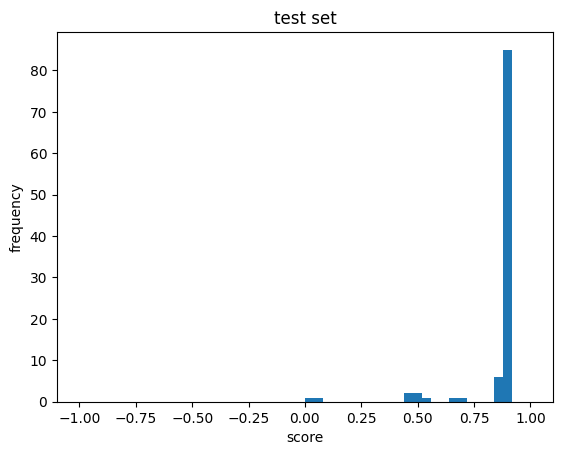

In [8]:
test_output_dict = {}
test_scores = []

for idx in range(0,100):

  batch_labels, batch_strs, batch_tokens = batch_converter([("Ezy_seq", df.iloc[idx, 1])])
  batch_tokens = batch_tokens.cuda()
  with torch.no_grad():
    token = model_esm(batch_tokens, repr_layers=[33], return_contacts=False)["representations"][33].cpu()

  sample = {'Enzyme': token[:, 1 : batch_tokens.size(1) - 1].mean(1), 'Reaction': torch.tensor([rxnfp_generator.convert(df.iloc[idx, 2])])}

  with torch.no_grad():
    model.eval()

  score = model.forward(sample['Enzyme'],sample['Reaction']).item()
  test_scores.append(score)
  test_output_dict.update({idx:(score)})

sorted_test_output = dict(sorted(test_output_dict.items(), key=lambda item: item[1], reverse=True))


print("test_mean:",np.mean(test_scores))
print("test_std:",np.std(test_scores))
print("top 10 in test set")
for  value in list(sorted_test_output.items())[:10]:  # show the top ten scores in set
    print(value)
print("bottom 10 in test set")
for  value in list(sorted_test_output.items())[-10:]:  # show the bottom ten scores in set
    print(value)

plt.hist(list(sorted_test_output.values()),bins = 50, range = [-1,1])

plt.xlabel("score")
plt.ylabel("frequency")
plt.title('test set')

# Show plot
plt.show()

Evaluating the validation dataset

val_mean: 0.14547847351059318
val_std: 0.6097180303798275
top 10 in validation set
(3676, 0.8950376510620117)
(3675, 0.8950287699699402)
(3606, 0.8948826789855957)
(3610, 0.8948163390159607)
(3601, 0.8946592807769775)
(3685, 0.8945515155792236)
(3684, 0.8945320248603821)
(3605, 0.8945286870002747)
(3636, 0.894411027431488)
(3662, 0.8943936824798584)
bottom 10 in validation set
(4848, -0.5175920724868774)
(4632, -0.5183719396591187)
(4317, -0.518610954284668)
(4648, -0.518958568572998)
(4589, -0.5204085111618042)
(4697, -0.5232557654380798)
(4585, -0.5268552899360657)
(4587, -0.539944052696228)
(4586, -0.5399503707885742)
(4584, -0.5415120720863342)


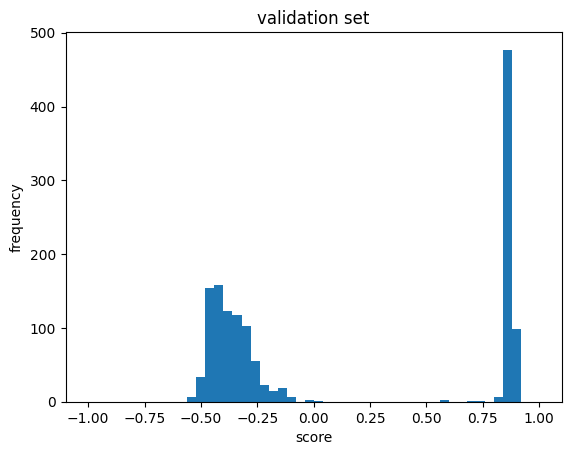

In [9]:
val_output_dict = {}
val_scores = []

for idx in range(3600,5000):

  batch_labels, batch_strs, batch_tokens = batch_converter([("Ezy_seq", df.iloc[idx, 1])])
  batch_tokens = batch_tokens.cuda()
  with torch.no_grad():
    token = model_esm(batch_tokens, repr_layers=[33], return_contacts=False)["representations"][33].cpu()

  sample = {'Enzyme': token[:, 1 : batch_tokens.size(1) - 1].mean(1), 'Reaction': torch.tensor([rxnfp_generator.convert(df.iloc[idx, 2])])}

  with torch.no_grad():
    model.eval()

  score = model.forward(sample['Enzyme'],sample['Reaction']).item()
  val_scores.append(score)
  val_output_dict.update({idx:(score)})

sorted_val_output = dict(sorted(val_output_dict.items(), key=lambda item: item[1], reverse=True))

print("val_mean:",np.mean(val_scores))
print("val_std:",np.std(val_scores))
print("top 10 in validation set")
for  value in list(sorted_val_output.items())[:10]:  # show the top ten scores in set
    print(value)
print("bottom 10 in validation set")
for  value in list(sorted_val_output.items())[-10:]:  # show the bottom ten scores in set
    print(value)

plt.hist(list(sorted_val_output.values()),bins = 50, range = [-1,1])

plt.xlabel("score")
plt.ylabel("frequency")
plt.title('validation set')

# Show plot
plt.show()

Evaluating the training dataset

train_mean: 0.8718256188035012
train_std: 0.04339185655054696
top 10 in training set
(3332, 0.8984107971191406)
(3202, 0.8979640007019043)
(3216, 0.8975646495819092)
(3353, 0.8975293636322021)
(3321, 0.8973973989486694)
(3269, 0.8973498344421387)
(3418, 0.8973464369773865)
(3235, 0.8972275257110596)
(3312, 0.8970944881439209)
(3311, 0.8970295190811157)
bottom 10 in training set
(1957, 0.8295199871063232)
(1500, 0.8094339370727539)
(3196, 0.7606631517410278)
(3395, 0.6140681505203247)
(3554, -0.06494984775781631)
(3381, -0.10352804511785507)
(3530, -0.10812990367412567)
(3404, -0.11051727831363678)
(3471, -0.11629099398851395)
(3223, -0.11896409839391708)


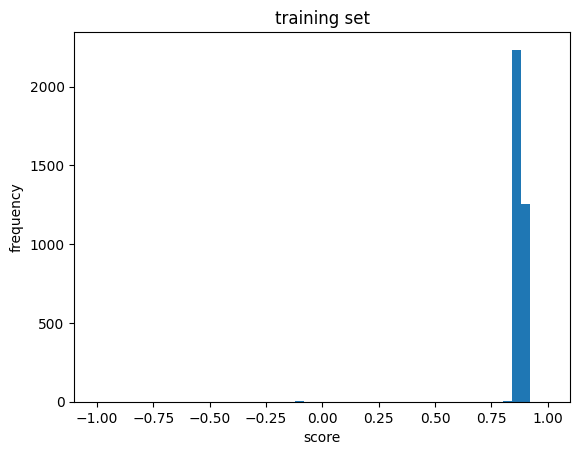

In [10]:
train_output_dict = {}
train_scores = []

for idx in range(100,3600):

  batch_labels, batch_strs, batch_tokens = batch_converter([("Ezy_seq", df.iloc[idx, 1])])
  batch_tokens = batch_tokens.cuda()
  with torch.no_grad():
    token = model_esm(batch_tokens, repr_layers=[33], return_contacts=False)["representations"][33].cpu()

  sample = {'Enzyme': token[:, 1 : batch_tokens.size(1) - 1].mean(1), 'Reaction': torch.tensor([rxnfp_generator.convert(df.iloc[idx, 2])])}

  with torch.no_grad():
    model.eval()

  score = model.forward(sample['Enzyme'],sample['Reaction']).item()
  train_scores.append(score)
  train_output_dict.update({idx:(score)})

sorted_train_output = dict(sorted(train_output_dict.items(), key=lambda item: item[1], reverse=True))

print("train_mean:",np.mean(train_scores))
print("train_std:",np.std(train_scores))
print("top 10 in training set")
for  value in list(sorted_train_output.items())[:10]:  # show the top ten scores in set
    print(value)
print("bottom 10 in training set")
for  value in list(sorted_train_output.items())[-10:]:  # show the bottom ten scores in set
    print(value)

plt.hist(list(sorted_train_output.values()),bins = 50, range = [-1,1])

plt.xlabel("score")
plt.ylabel("frequency")
plt.title('training set')

# Show plot
plt.show()

Evaluating random data

random_mean: -0.07882503924891353
random_std: 0.34881015778991253
top 10 in random set
(246290, 0.8517909049987793)
(239677, 0.8208837509155273)
(73759, 0.8056073188781738)
(284786, 0.7275862097740173)
(164560, 0.7132173776626587)
(202092, 0.6309592723846436)
(72686, 0.630355179309845)
(200990, 0.6219902038574219)
(197665, 0.5671846866607666)
(200321, 0.5639773607254028)
bottom 10 in random set
(7961, -0.3887740969657898)
(10760, -0.40140360593795776)
(273921, -0.4107666611671448)
(163305, -0.41259944438934326)
(275154, -0.42294150590896606)
(119293, -0.4277211129665375)
(277300, -0.4516531229019165)
(10712, -0.4619535505771637)
(88687, -0.5089024901390076)
(218228, -0.6270453929901123)


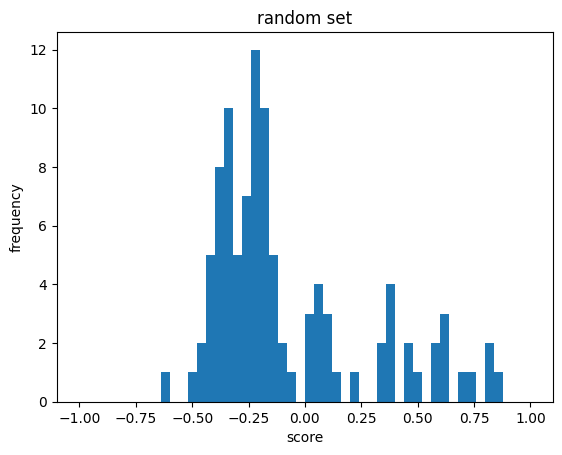

In [11]:
random_output_dict = {}
random_scores = []
L = len(df)

for i in range(0,100):
  idx = random.randint(5000,L)
  batch_labels, batch_strs, batch_tokens = batch_converter([("Ezy_seq", df.iloc[idx, 1])])
  batch_tokens = batch_tokens.cuda()
  with torch.no_grad():
    token = model_esm(batch_tokens, repr_layers=[33], return_contacts=False)["representations"][33].cpu()

  sample = {'Enzyme': token[:, 1 : batch_tokens.size(1) - 1].mean(1), 'Reaction': torch.tensor([rxnfp_generator.convert(df.iloc[idx, 2])])}

  with torch.no_grad():
    model.eval()

  score = model.forward(sample['Enzyme'],sample['Reaction']).item()
  random_scores.append(score)
  random_output_dict.update({idx:(score)})

sorted_random_output = dict(sorted(random_output_dict.items(), key=lambda item: item[1], reverse=True))

print("random_mean:",np.mean(random_scores))
print("random_std:",np.std(random_scores))
print("top 10 in random set")
for  value in list(sorted_random_output.items())[:10]:  # show the top ten scores in set
    print(value)
print("bottom 10 in random set")
for  value in list(sorted_random_output.items())[-10:]:  # show the bottom ten scores in set
    print(value)


plt.hist(list(sorted_random_output.values()),bins = 50, range = [-1,1])
plt.xlabel("score")
plt.ylabel("frequency")
plt.title('random set')
plt.show()